In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../")

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import pandas as pd
from project.utils.ds.structures import MaskedExample, Example
from project.utils.box_utils import box_from_single_segmask
from tqdm import tqdm
import dataclasses as dc
from project.utils.ds import images as img_utils
from PIL import ImageOps

In [4]:
train_path = Path("../data/stage1_train/")
test_path = Path("../data/stage1_test/")

In [6]:
train_dirs = list(train_path.iterdir())
test_dirs = list(test_path.iterdir())

train_examples = [
    dc.replace(MaskedExample.from_path(p), masks=None)
    for p in tqdm(train_dirs[:])
]

test_examples = [
    Example.from_path(p)
    for p in tqdm(test_dirs[:])
]

len(train_examples), len(test_examples)

100%|██████████| 65/65 [00:00<00:00, 5154.56it/s]


(670, 65)

Plot a few examples

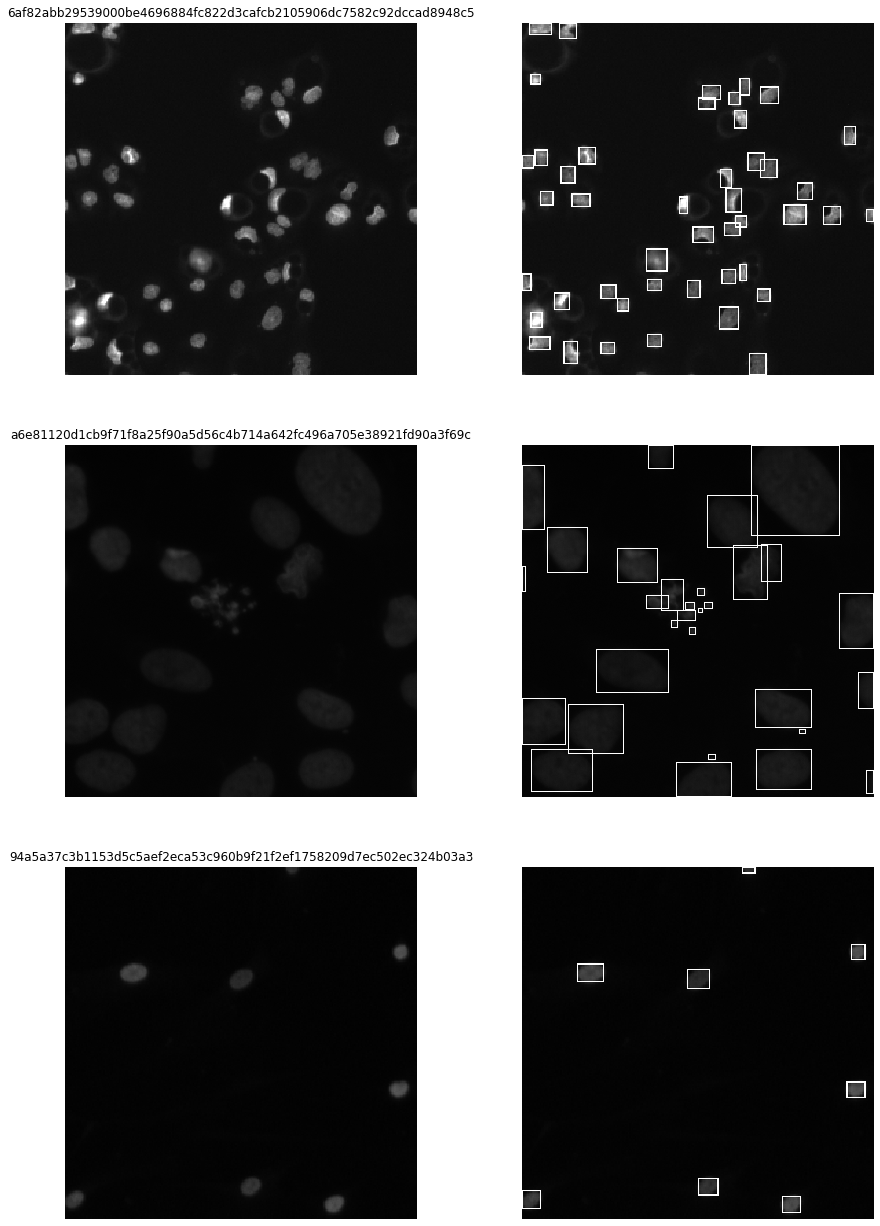

In [7]:
plt.figure(figsize=(15, 22))
for i in range(3):
    
    ex = train_examples[i]
    plt.subplot(3, 2, 1 + 2* i)
    plt.title(ex.name)
    plt.imshow(ex.image)
    plt.axis("off")
    plt.subplot(3, 2, 2 + 2* i)

    plt.imshow(ex.vis_boxes())
    plt.axis("off")

    

# Questions

* photos
     * sizes
     * aspect ratios
     * intensities
         * means
         * stds
         * are they related?
     * types (grayscale, RGB, RGBA)

* objects
    * counts
    * sizes
        * absolute
        * relative to photo size
        * std in a single photo
        * std in the whole dataset
    * shapes
    * coordinates
    * color intensities of box objects 
        * as opposed to the entire image


# Photos
## Sizes

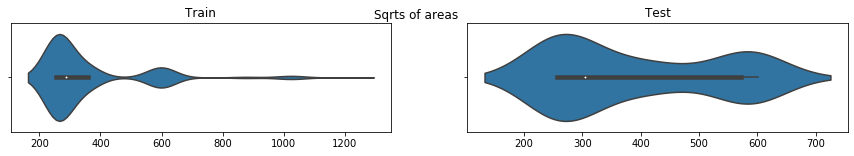

In [119]:
plt.figure(figsize=(15, 2))
plt.suptitle("Sqrts of areas")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot([np.sqrt(np.multiply(*ex.image.size)) for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot([np.sqrt(np.multiply(*ex.image.size)) for ex in test_examples])

plt.show()

## Aspect ratios

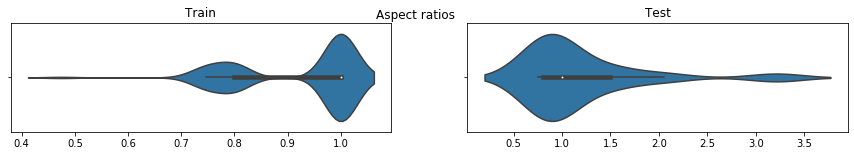

In [121]:

plt.figure(figsize=(15, 2))
plt.suptitle("Aspect ratios")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot([ex.image.height / ex.image.width for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot([ex.image.height / ex.image.width for ex in test_examples]) 

plt.show()

## Modes

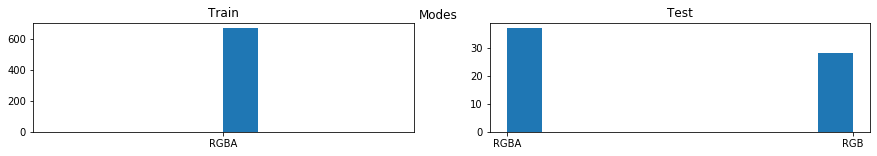

In [99]:
plt.figure(figsize=(15, 2))
plt.suptitle("Modes")
plt.subplot(1, 2, 1)
plt.title("Train")
plt.hist([ex.image.mode for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

plt.hist([ex.image.mode for ex in test_examples]) 

plt.show()

## Grayscales

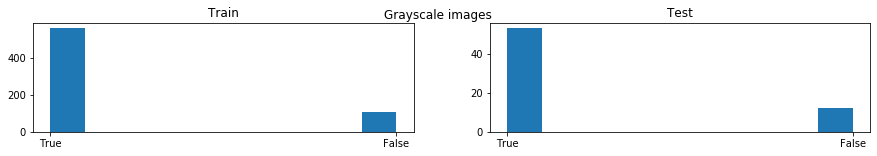

In [100]:
plt.figure(figsize=(15, 2))
plt.suptitle("Grayscale images")
plt.subplot(1, 2, 1)
plt.title("Train")
plt.hist([str(img_utils.is_grayscale(ex.image)) for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

plt.hist([str(img_utils.is_grayscale(ex.image)) for ex in test_examples]) 
plt.show()

In [88]:
ex = train_examples[0]
np.std(np.asarray(ex.image)[:, :, :3], axis=2).mean()#.shape #for ex in train_examples]


True

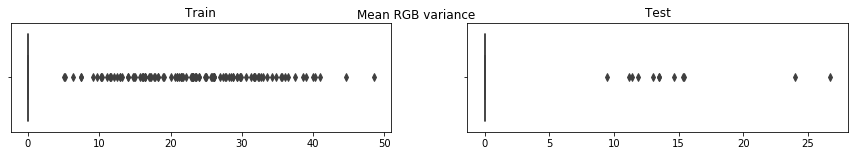

In [140]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean RGB variance")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.boxplot([np.std(np.asarray(ex.image)[:, :, :3], axis=2).mean() for ex in train_examples]) 
plt.subplot(1, 2, 2)

plt.title("Test")

sns.boxplot([np.std(np.asarray(ex.image)[:, :, :3], axis=2).mean() for ex in test_examples]) 

plt.show()

In [108]:
most_variant_examples = sorted(
    train_examples,
    key = lambda ex: np.std(np.asarray(ex.image)[:, :, :3], axis=2).mean(),
    reverse=True
)

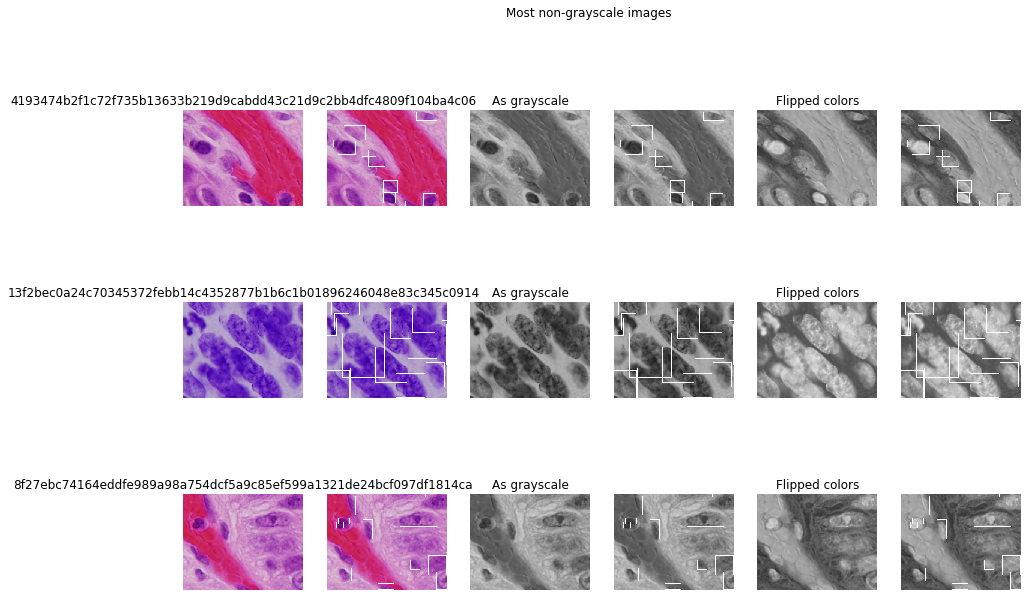

In [139]:
plt.figure(figsize=(15, 10))
plt.suptitle("Most non-grayscale images")
n_rows = 6
for i, ex in enumerate(most_variant_examples[:3]):
    
    plt.subplot(3, n_rows, 1 + n_rows* i)
    plt.title(ex.name)
    plt.imshow(ex.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 2 + n_rows* i)
    plt.imshow(ex.vis_boxes())
    plt.axis("off")

    ex_grayscale = dc.replace(ex, image=ex.image.convert("LA").convert("RGB"))
    plt.subplot(3, n_rows, 3 + n_rows* i)
    plt.title("As grayscale")
    plt.imshow(ex_grayscale.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 4 + n_rows* i)
    plt.imshow(ex_grayscale.vis_boxes())
    plt.axis("off")
    
    ex_flipped = dc.replace(ex_grayscale, image=ImageOps.invert(ex_grayscale.image))
    plt.subplot(3, n_rows, 5 + n_rows* i)
    plt.title("Flipped colors")
    plt.imshow(ex_flipped.image)
    plt.axis("off")
    plt.subplot(3, n_rows, 6 + n_rows* i)
    plt.imshow(ex_flipped.vis_boxes())
    plt.axis("off")

## Intensities

In [163]:
train_means, test_means = [
    np.array([np.asarray(ex.image.convert("RGB")).mean() for ex in ds])
    for ds in [train_examples, test_examples]
]

train_stds, test_stds = [
    np.array([np.asarray(ex.image.convert("RGB")).std() for ex in ds])
    for ds in [train_examples, test_examples]
]

train_maxs, test_maxs = [
    np.array([np.asarray(ex.image.convert("RGB")).max() for ex in ds])
    for ds in [train_examples, test_examples]
]


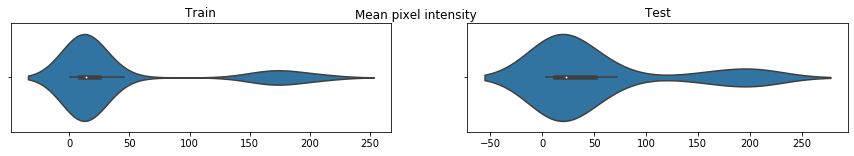

In [157]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_means) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_means) 

plt.show()

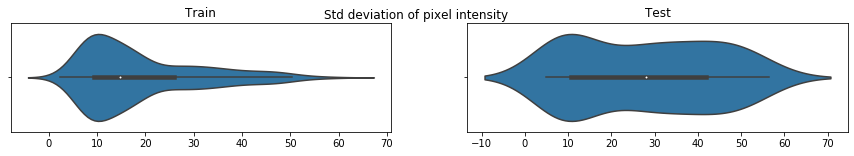

In [158]:
plt.figure(figsize=(15, 2))
plt.suptitle("Std deviation of pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_stds) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_stds) 

plt.show()

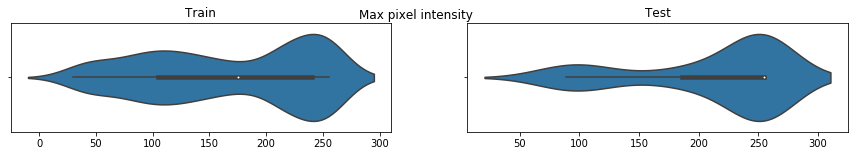

In [159]:
plt.figure(figsize=(15, 2))
plt.suptitle("Max pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
sns.violinplot(train_maxs) 
plt.subplot(1, 2, 2)

plt.title("Test")
sns.violinplot(test_maxs) 

plt.show()

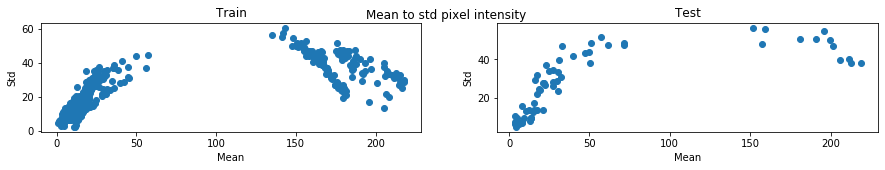

In [161]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean to std pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")
plt.xlabel("Mean")
plt.ylabel("Std")
plt.scatter(train_means, train_stds)
plt.subplot(1, 2, 2)

plt.title("Test")
plt.xlabel("Mean")
plt.ylabel("Std")
plt.scatter(test_means, test_stds)

plt.show()

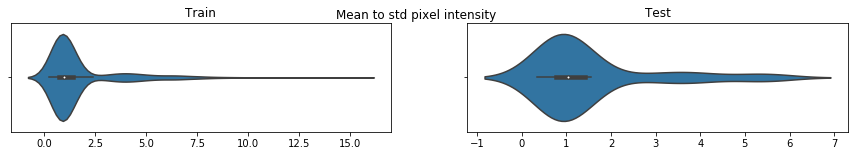

In [166]:
plt.figure(figsize=(15, 2))
plt.suptitle("Mean to std pixel intensity")

plt.subplot(1, 2, 1)
plt.title("Train")

sns.violinplot(train_means / train_stds)
plt.subplot(1, 2, 2)

plt.title("Test")

sns.violinplot(test_means / test_stds)

plt.show()